<a href="https://colab.research.google.com/github/diascarolina/i2a2/blob/main/exercise02/problem02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 02: Preparing the Titanic Dataset

**Author:** Carolina Araujo Dias

---

In this problem, we use de CRISP-DS methodology to clean, prepare and analyze the well-known Titanic dataset. CRISP-DS is an adaptation for Data Science of the cyclic methodology CRISP-DM (_Cross Industry Standard Process for Data Mining_). [[1]](https://blog.magrathealabs.com/crisp-ds-cyclic-methodology-for-data-science-projects-10c7d00fbc85)


These are the steps involved in the CRISP-DS methodology:

![](https://raw.githubusercontent.com/diascarolina/i2a2/main/img/crisp-ds.png)

Since this is a fairly straightforward problem, we only need to go through the cycle once.

Our **Business Problem** is to predict whether a passenger survived the sinking of Titanic. This is a famous dataset generally used to learn about Data Science and Machine Learning, and it can also be found at Kaggle:

- [Kaggle Problem: "Titanic - Machine Learning from Disaster"](https://www.kaggle.com/c/titanic)

# 1 Business Understanding

From the Kaggle Problem page:

> The sinking of the Titanic is one of the most infamous shipwrecks in history.
>
> On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.
>
> While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

# 2 Data Extraction

We don't need to extract this data, since it is already given to us. So, in this step, let's import the necessary libraries and load up the data into the notebook.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

In [7]:
df_train_raw = pd.read_excel('https://github.com/diascarolina/i2a2/blob/main/exercise02/train.xlsx?raw=true')
df_test_raw = pd.read_excel('https://github.com/diascarolina/i2a2/blob/main/exercise02/test.xlsx?raw=true')

# 3 Data Cleaning & EDA

Let's first understand the data that we have here by checking what each column means by looking at its data dictionary.

- **Kaggle_Pass_Id**: the id of a person (used on Kaggle)
- **pclass**: ticket class,	1 = 1st, 2 = 2nd, 3 = 3rd
- **survived**: whether someone survived or not (0 no, 1 yes)
- **name**: the name of a person
- **sex**: the gender of a person
- **age**: the age of a person
- **sibsp**: number of siblings / spouses aboard the Titanic
- **parch**: number of parents / children aboard the Titanic
- **ticket**: ticket number
- **fare**: passenger fare
- **cabin**: cabin number
- **embarked**: port of embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

The following information are not provided in the data dictionary:
- **boat**
- **body**
- **home.dest**
- **orig_seq** 

Let's check the first five lines of the datasets (train and test), to get a general look for the data.

In [8]:
df_train = df_train_raw.copy()
df_test = df_test_raw.copy()

In [9]:
df_train.head()

,Kaggle_Pass_Id,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,orig_seq
0,1,3,0,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,NaN,"Bridgerule, Devon",690
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4,NaN,"New York, NY",86
2,3,3,1,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,NaN,NaN,861
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,D,NaN,"Scituate, MA",128
4,5,3,0,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,NaN,"Lower Clapton, Middlesex or Erdington, Birmingham",619


In [10]:
df_test.head()

,Kaggle_Pass_Id,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,orig_seq
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,NaN,70.0,NaN,925
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,NaN,NaN,NaN,1291
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,NaN,NaN,"Cambridge, MA",512
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,NaN,131.0,NaN,1297
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,15,NaN,NaN,868


In [11]:
print(f'We have {df_train.shape[0]} rows and {df_train.shape[1]} columns in the train dataset.')
print(f'We have {df_test.shape[0]} rows and {df_test.shape[1]} columns in the test dataset.')

We have 891 rows and 16 columns in the train dataset.
We have 418 rows and 15 columns in the test dataset.


We can see that in the `test` dataset we have one less column than in the `train` dataset. The column missing is the `survived` columns, because it is what we have to predict. But, in my opinion, this column should be provided for us to compare our results with the real prediction.

What is the data type of the columns?

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Kaggle_Pass_Id  891 non-null    int64  
 1   pclass          891 non-null    int64  
 2   survived        891 non-null    int64  
 3   name            891 non-null    object 
 4   sex             891 non-null    object 
 5   age             714 non-null    float64
 6   sibsp           891 non-null    int64  
 7   parch           891 non-null    int64  
 8   ticket          891 non-null    object 
 9   fare            891 non-null    float64
 10  cabin           204 non-null    object 
 11  embarked        889 non-null    object 
 12  boat            330 non-null    object 
 13  body            83 non-null     float64
 14  home.dest       499 non-null    object 
 15  orig_seq        891 non-null    int64  
dtypes: float64(3), int64(6), object(7)
memory usage: 111.5+ KB


What about missing values in the data?

In [13]:
df_train.isna().sum()

Kaggle_Pass_Id      0
pclass              0
survived            0
name                0
sex                 0
age               177
sibsp               0
parch               0
ticket              0
fare                0
cabin             687
embarked            2
boat              561
body              808
home.dest         392
orig_seq            0
dtype: int64

From this we can see that a lot of columns have missing data. What should we do about them?

Here, the only variable we can treat the null values is the `age` columns. The other columns have the majority of data as null values, so we'll drop these columns.

In [14]:
df_train = df_train.drop(['cabin', 'boat', 'body', 'home.dest'], axis = 1)

In [15]:
df_train.isna().sum()

Kaggle_Pass_Id      0
pclass              0
survived            0
name                0
sex                 0
age               177
sibsp               0
parch               0
ticket              0
fare                0
embarked            2
orig_seq            0
dtype: int64

We still have 2 missing values in the column `embarked`. Since this is a small number, we can change the null values to the most common one.

In [16]:
df_train.embarked.value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [17]:
df_train.embarked[df_train.embarked.isna()] = 'S'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
df_train.isna().sum()

Kaggle_Pass_Id      0
pclass              0
survived            0
name                0
sex                 0
age               177
sibsp               0
parch               0
ticket              0
fare                0
embarked            0
orig_seq            0
dtype: int64

Now, for the `age` column, we'll substitute the missing values with the mean.

In [19]:
df_train.age = df_train.age.fillna(df_train.age.mean())

In [20]:
df_train.isna().sum()

Kaggle_Pass_Id    0
pclass            0
survived          0
name              0
sex               0
age               0
sibsp             0
parch             0
ticket            0
fare              0
embarked          0
orig_seq          0
dtype: int64

Let's check the statistical part of the data, but first, let's change the values in the `sex` columns such as:

- **female**: 0
- **male**: 1

In [21]:
df_train.sex = df_train.sex.map({'female': '0', 'male': '1'}).astype(float)

In [22]:
df_train.describe()

,Kaggle_Pass_Id,pclass,survived,sex,age,sibsp,parch,fare,orig_seq
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,0.383838,0.647587,29.699113,0.523008,0.381594,32.204208,662.304153
std,257.353842,0.836071,0.486592,0.477990,13.002024,1.102743,0.806057,49.693429,378.282967
min,1.000000,1.000000,0.000000,0.000000,0.416700,0.000000,0.000000,0.000000,1.000000
25%,223.500000,2.000000,0.000000,0.000000,22.000000,0.000000,0.000000,7.910400,335.500000
50%,446.000000,3.000000,0.000000,1.000000,29.699113,0.000000,0.000000,14.454200,666.000000
75%,668.500000,3.000000,1.000000,1.000000,35.000000,1.000000,0.000000,31.000000,993.500000
max,891.000000,3.000000,1.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1309.000000


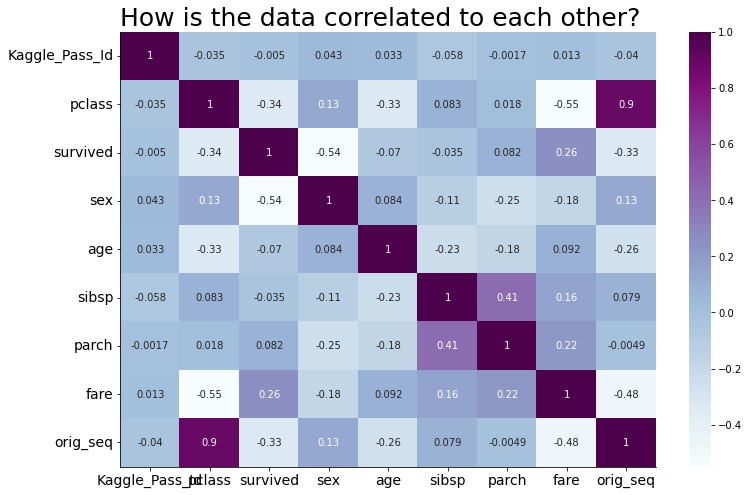

In [23]:
plt.figure(figsize = (12, 8))
sns.heatmap(df_train.corr(), cmap = "BuPu", annot = True)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('How is the data correlated to each other?', fontdict = {'fontsize': 25}, loc = 'left')
sns.despine()
plt.show()

From the above heatmap we see that the variables that most influence the `survived` target are:

- sex
- pclass
- fare
- orig_seq

Does this make sense from our point of view?

Yes! It is well-known that when the Titanic was sinking the first people saved were "women and children first". So it makes sense that most women survived instead of men. It is also surprising that age dosn't have that high of a correlation with the survived target.

Also, `pclass`, `fare` and `orig_seq` have high correlation with the survived class because they are variables related to the socio-economic class of a person, and people in higher classes were saved first.

## 3.1 Variables Check

Now let's check visually for the distribution of variables.

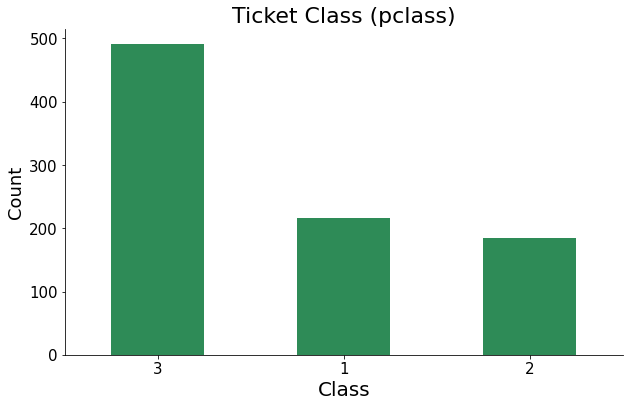

In [24]:
df_train.pclass.value_counts().plot(kind = 'bar', figsize = (10, 6), color = 'seagreen')
plt.title('Ticket Class (pclass)', fontsize = 22)
plt.xticks(rotation = 0, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Class', fontsize = 20)
plt.ylabel('Count', fontsize = 18)
sns.despine()
plt.show()

More people were in the 3rd class.

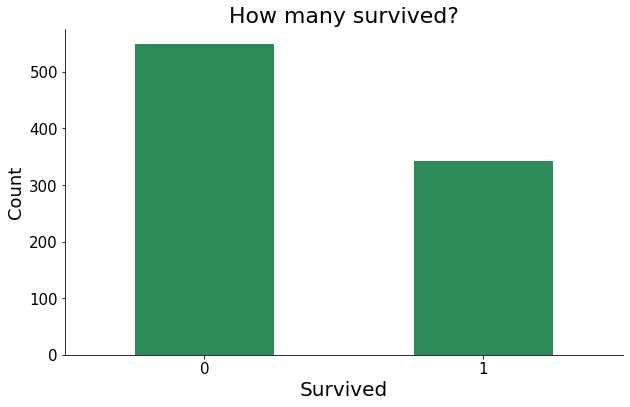

In [25]:
df_train.survived.value_counts().plot(kind = 'bar', figsize = (10, 6), color = 'seagreen')
plt.title('How many survived?', fontsize = 22)
plt.xticks(rotation = 0, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Survived', fontsize = 20)
plt.ylabel('Count', fontsize = 18)
sns.despine()
plt.show()

More people died than survived.

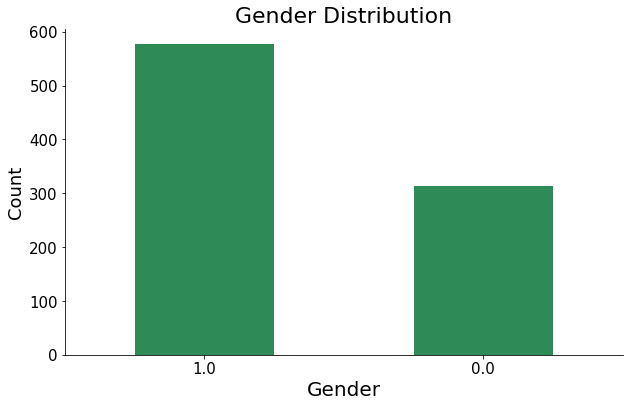

In [26]:
df_train.sex.value_counts().plot(kind = 'bar', figsize = (10, 6), color = 'seagreen')
plt.title('Gender Distribution', fontsize = 22)
plt.xticks(rotation = 0, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Gender', fontsize = 20)
plt.ylabel('Count', fontsize = 18)
sns.despine()
plt.show()

More men than women in the Titanic.

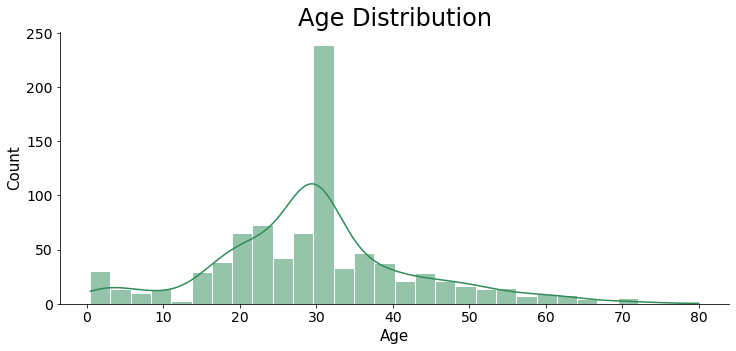

In [27]:
plt.figure(figsize = (12, 5))
plt.title("Age Distribution", fontdict = {'fontsize': 24})
sns.set_style("white")
ax = sns.histplot(df_train.age, kde = True, color = 'seagreen')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
sns.despine()
plt.show()

The majority of people were about 30 years of age.

# 4 Data Preparation

From the above analysis we can see that some variables are more relavant than other in the prediction of the survived target. So let's take the other variables out of the dataframe. Let's fill the missing values as well, as we did above.

In [28]:
def data_preprocessing(df):
    selected_columns = ['pclass', 'sex', 'fare']
    df.sex = df.sex.map({'female': '0', 'male': '1'}).astype(float)
    return df[selected_columns]

In [29]:
X_train = data_preprocessing(df_train_raw)
y_train = df_train.survived

X_test = data_preprocessing(df_test_raw)

In [30]:
X_train.isna().sum()

pclass    0
sex       0
fare      0
dtype: int64

In [31]:
X_test.isna().sum()

pclass    0
sex       0
fare      1
dtype: int64

In [32]:
X_test.fare = X_test.fare.fillna(X_test.fare.mean())

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# 5 Modelling

For this part, we'll be using one of the most famous and used model: the Random Forest Classifier. Most of the time, its results are good enough for what we want to do. The won't be any hyperparameter tuning.

We could also use a dummy model to check what the accuracy would be in the worst case scenario, by predicting that everyone didn't survive.

In [33]:
# initializing, fitting and predicting with the model
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_preds = rfc.predict(X_test)

To evaluate our model we need to have the `survived` column in the test set. Since the provided data doesn't have it, we'll be using the Kaggle competition page to evaluate it.

In [34]:
# preparing the submission in the Kaggle format
submission = pd.DataFrame()
submission['PassengerId'] = df_test_raw['Kaggle_Pass_Id']
submission['Survived'] = y_preds

# uncomment the following line to download the .csv
# submission.to_csv('submission.csv', index=False)

After submitting, our model got an accuracy of 0.77511.

![](https://raw.githubusercontent.com/diascarolina/i2a2/main/img/KaggleScore.png)

# 6 Deployment

Our next step in the CRISP-DS method would be to deploy our model, but this is beyond the scope of this lesson.

One way we could deploy our model is by making a simple API that receives a request with the passanger information and returns if that person would have survived the sinking of Titanic. We could do this using Flask or FastAPI and deploy it using Docker or any cloud provider.

# 7 References

- [[1] CRISP-DS: Cyclic Methodology for Data Science Projects](https://blog.magrathealabs.com/crisp-ds-cyclic-methodology-for-data-science-projects-10c7d00fbc85)
- [Kaggle Problem: Titanic](https://www.kaggle.com/c/titanic/overview)